In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
import calendar
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestRegressor

In [3]:
# 讀取訓練資料
dailyData = pd.read_csv('train.csv')

In [4]:
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [5]:
# 處理時間格式: 
# 1. 將時間拆成日期、小時、星期幾、月份
# 2. 將"season","holiday","workingday"和"weather" 轉成category資料
# 3. 去除去除無用的特徵,"datatime"
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [6]:
# 將參數轉為類別型資料
# 常見的處理方式: One-hot encoding
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

# 去除無用的特徵
dailyData  = dailyData.drop(["datetime"],axis=1)

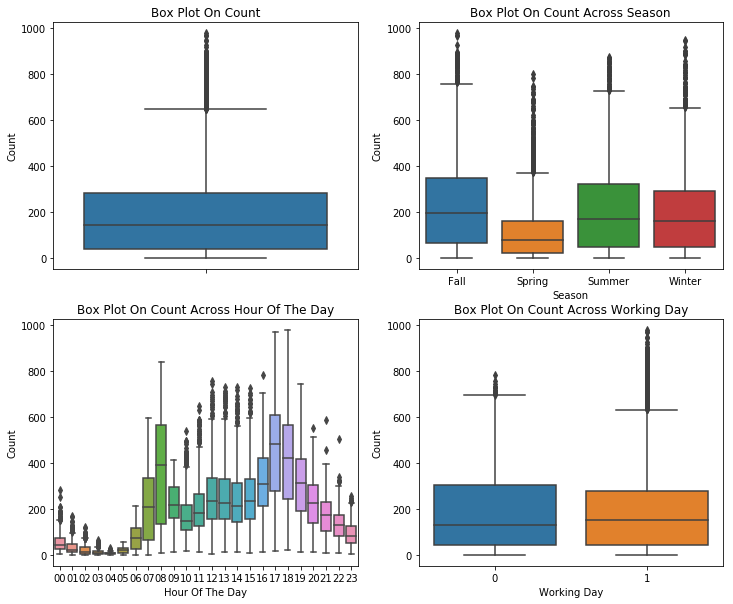

In [7]:
# Outlier analysis
# 1. spring的出租量(count)較低。
# 2. 平均的出租量在7AM-8AM，5PM-6PM較高，推測是上下班的尖峰時間造成的。
# 3. 大部分的Outliers分布在工作日(workingday)。
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
plt.show()

In [8]:
# 發現count欄位有許多Outliers，可以使用最簡單的超出三倍標準差概念將這些Outlier先去掉
print ('Shape Of Train Before Removing Outliers: ', dailyData.shape)
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 
print ('Shape Of Train After Outliers', dailyDataWithoutOutliers.shape)

Shape Of Train Before Removing Outliers:  (10886, 15)
Shape Of Train After Outliers (10739, 15)


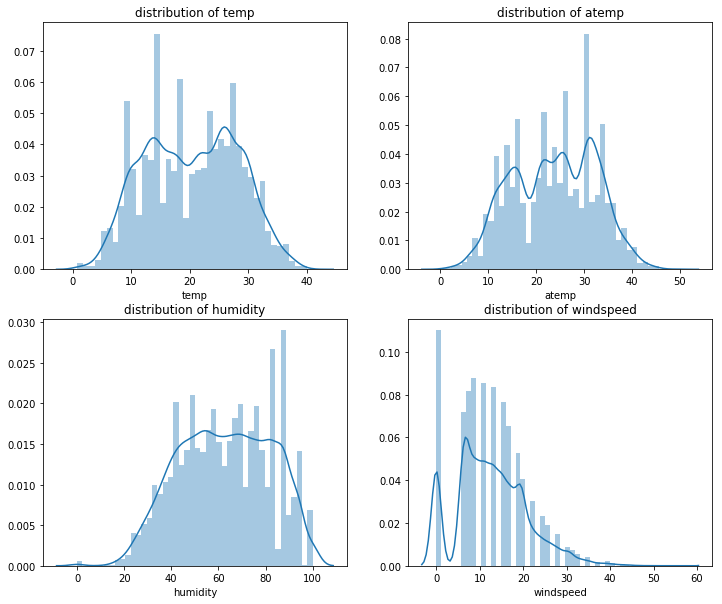

In [13]:
# 觀察參數如temp, atemp, humidity,...,資料分布的情況
# 合併train和test
dataTrain = pd.read_csv("train.csv")
dataTest = pd.read_csv("test.csv")

data = dataTrain.append(dataTest, sort=True)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.distplot(data["temp"],ax=axes[0][0])
sn.distplot(data["atemp"],ax=axes[0][1])
sn.distplot(data["humidity"],ax=axes[1][0])
sn.distplot(data["windspeed"],ax=axes[1][1])

axes[0][0].set(xlabel='temp',title="distribution of temp")
axes[0][1].set(xlabel='atemp',title="distribution of atemp")
axes[1][0].set(xlabel='humidity',title="distribution of humidity")
axes[1][1].set(xlabel='windspeed',title="distribution of windspeed")
plt.show()

In [15]:
# 特徵工程
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

C:\Users\waukin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\waukin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\waukin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[

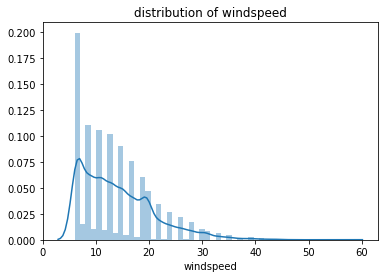

In [16]:
# 發現風速為0的值相當多，可以解釋成風速太小量不到或是只要是風速為空值都被資料提供方補上0，因此需將風速為0的值重新估計，
# 將風速分為0及不為0的兩類資料，用風速不為0的資料來訓練random forest模型，將訓練好的模型來預測風速為0的值為何
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

# 畫出補遺好的風速分布圖
fig, ax = plt.subplots(nrows=1,ncols=1)
sn.distplot(data['windspeed'])
ax.set(xlabel='windspeed',title="distribution of windspeed")
plt.show()

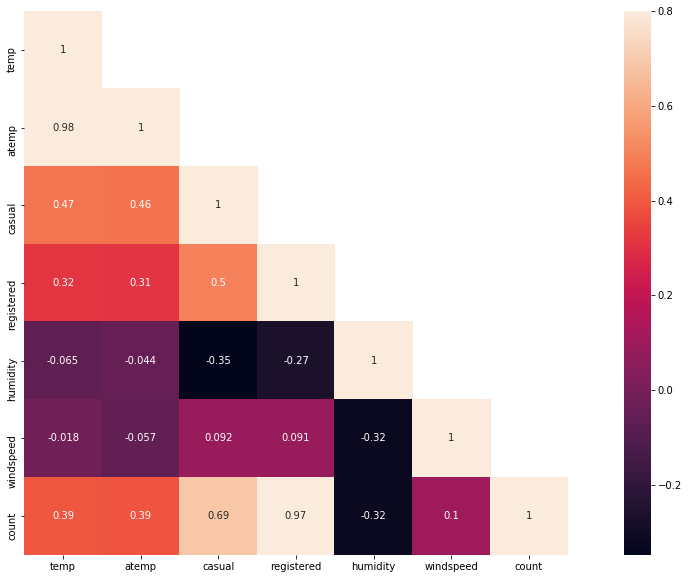

In [17]:
# 相關性分析
# 1. temp和humidity對於count有正負相關性
# 2. windspeed和count的相關性很低
# 3. atemp和temp具高度相關性
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

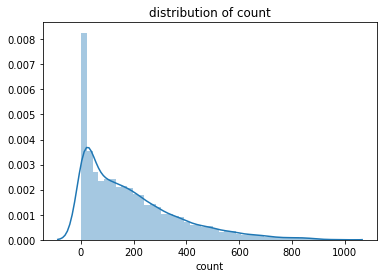

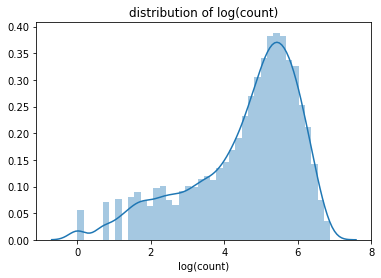

In [18]:
# 觀察單車出借數量(count)分布
# 其分布非常歪斜(Skew)，透過取log使資料分布接近Normal distribution
fig, ax = plt.subplots(nrows=1,ncols=1)
sn.distplot(dailyData['count'])
ax.set(xlabel='count',title="distribution of count")
plt.show()

fig, ax = plt.subplots(nrows=1,ncols=1)
sn.distplot(dailyData['count'].apply(lambda x: np.log(x)))
ax.set(xlabel='log(count)',title="distribution of log(count)")
plt.show()

In [19]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsLog = np.log(yLabels)

# 去除用不到的特徵
dropFeatures = ['casual',"count","datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [20]:
# Random forest進行預測
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
yLabelsLog = np.log(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X=dataTrain)

predsTest = rfModel.predict(X=dataTest)
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_RF_R.csv', index=False)

In [21]:
submission.head(10)

,datetime,count
9573,2011-01-20 00:00:00,10.844260
16512,2011-01-20 01:00:00,4.821706
16513,2011-01-20 02:00:00,2.862514
9574,2011-01-20 03:00:00,3.018815
9575,2011-01-20 04:00:00,2.527800
9576,2011-01-20 05:00:00,5.171146
9577,2011-01-20 06:00:00,35.110509
9578,2011-01-20 07:00:00,91.316420
9579,2011-01-20 08:00:00,207.086086
9580,2011-01-20 09:00:00,121.925850
